In [1]:
# 自动计算cell的计算时间
%load_ext autotime

%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 12 ms (started: 2021-08-12 14:14:21 +08:00)


In [28]:
%%bash

# 增加更新
git add *.ipynb

git remote -v

git commit -m '更新 ch3 #4 change Aug 12, 2021'

git push origin master

origin	git@github.com:ustchope/Advanced-Deep-Learning-with-Keras.git (fetch)
origin	git@github.com:ustchope/Advanced-Deep-Learning-with-Keras.git (push)
[master b1665aa] 更新 ch3 #4 change Aug 12, 2021
 2 files changed, 167 insertions(+), 102 deletions(-)


To git@github.com:ustchope/Advanced-Deep-Learning-with-Keras.git
   f82f5cb..b1665aa  master -> master


time: 4.5 s (started: 2021-08-12 16:44:44 +08:00)


In [27]:
#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

time: 1.59 ms (started: 2021-08-12 16:44:40 +08:00)


# 自编码器

在上一章，第 2 章，深度神经网络中，我们介绍了深度神经网络的概念。 我们现在将继续研究自动编码器，它是一种神经网络架构，试图找到给定输入数据的压缩表示。

与前几章类似，输入数据可能有多种形式，包括语音、文本、图像或视频。 自编码器将尝试找到一个表示或一段代码，以便对输入数据执行有用的转换。 例如，在对自动编码器进行去噪时，神经网络将尝试找到可用于将嘈杂数据转换为干净数据的代码。 嘈杂的数据可以是带有静态噪声的录音形式，然后将其转换为清晰的声音。 自编码器将仅从数据中自动学习代码，无需人工标记。 因此，自动编码器可以归类为无监督学习算法。

在本书后面的章节中，我们将介绍生成对抗网络 (GAN) 和变分自动编码器 (VAE)，它们也是无监督学习算法的代表形式。 这与我们在前几章讨论的监督学习算法形成对比，后者需要人工注释。

总之，本章介绍：
* 自编码器的原理
* 如何使用 tf.keras 实现自动编码器
* 去噪和着色自编码器的实际应用

让我们首先了解什么是自动编码器，以及自动编码器的原理。

## 自编码器的原理

在最简单的形式中，自动编码器将通过尝试将输入复制到输出来学习表示或代码。 然而，使用自动编码器并不像将输入复制到输出那么简单。 否则，神经网络将无法发现输入分布中的隐藏结构。

自编码器将输入分布编码为低维张量，通常采用向量的形式。 这将逼近通常称为潜在表示、代码或向量的隐藏结构。 这个过程构成了编码部分。 然后潜在向量将由解码器部分解码以恢复原始输入。

由于潜在向量是输入分布的低维压缩表示，因此应该预期解码器恢复的输出只能近似于输入。 输入和输出之间的差异可以通过损失函数来衡量。

但是我们为什么要使用自编码器呢？ 简而言之，自动编码器以其原始形式或作为更复杂神经网络的一部分而具有实际应用。

它们是理解深度学习高级主题的关键工具，因为它们为我们提供了适合密度估计的低维数据表示。 此外，它可以被有效地处理以对输入数据执行结构化操作。 常见的操作包括去噪、着色、特征级算法、检测、跟踪和分割，仅举几例。

在本节中，我们将介绍自编码器的原理。 我们将使用前面章节中介绍的 MNIST 数据集来研究自动编码器。

首先，我们需要知道一个自动编码器有两个操作符，它们是：
* **编码器**：这将输入 x 转换为低维潜在向量，$𝒛 = 𝑓(𝒙)$。 由于潜在向量是低维的，编码器被迫只学习输入数据中最重要的特征。 例如，在 MNIST 数字的情况下，要学习的重要特征可能包括书写风格、倾斜角度、笔画的圆度、粗细等。 从本质上讲，这些是表示数字 0 到 9 所需的最重要的信息位。
* **解码器**：这试图从潜在向量中恢复输入，$𝑔(𝒛) = \tilde{x}$。

虽然潜在向量的维度很低，但它有足够的大小来允许解码器恢复输入数据。

解码器的目标是使 $\tilde{x}$ 尽可能接近 $x$。 通常，编码器和解码器都是非线性函数。 z 的维度是它可以表示的显着特征数量的度量。 该维度通常比输入维度小得多，以提高效率，并且为了限制潜在代码仅学习输入分布的最显着属性。

当潜在代码的维度明显大于 x 时，自动编码器倾向于记住输入。

一个合适的损失函数 $ℒ(𝒙, \tilde{x})$ 是衡量输入 x 与输出的不同程度的度量，输出是恢复的输入 $\tilde{x}$。 如以下等式所示，均方误差 (MSE) 是此类损失函数的一个示例：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcvgdo95ej61a2068dg302.jpg)

在这个例子中，m 是输出维度（例如，在 MNIST 中，m = 宽度 × 高度 × 通道 = 28 × 28 × 1 = 784）。 $x_i$ 和 $\tilde{x}_i$ 分别是 $x$ 和 $\tilde{x}$ 的元素。 由于损失函数是输入和输出之间差异的度量，我们能够使用替代的重建损失函数，例如二元交叉熵或结构相似性指数 (SSIM)。

与其他神经网络类似，自编码器会在训练期间尝试使此误差或损失函数尽可能小。 图 3.1.1 显示了一个自动编码器。 编码器是一个将输入 $x$ 压缩为低维潜在向量 $z$ 的函数。 这个潜在向量代表了输入分布的重要特征。 然后，解码器尝试以 $\tilde{x}$ 的形式从潜在向量中恢复原始输入。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcvkbe28sj61d809mwf902.jpg)

为了将自动编码器放入上下文中，x 可以是一个 MNIST 数字，其维度为 28 × 28 × 1 = 784。编码器将输入转换为一个低维 z，它可以是一个 16 维的潜在向量。 解码器将尝试从 z 中恢复 $\tilde{x}$ 形式的输入。

从视觉上看，每个 MNIST 数字 x 看起来都类似于 $\tilde{x}$. 图 3.1.2 向我们展示了这个自动编码过程。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcvms57fmj61ca0cmdhc02.jpg)

我们可以观察到解码后的数字 7 虽然不完全相同，但仍然足够接近。 由于编码器和解码器都是非线性函数，我们可以使用神经网络来实现两者。 例如，在 MNIST 数据集中，自动编码器可以通过 MLP 或 CNN 实现。 可以通过反向传播最小化损失函数来训练自编码器。 与其他神经网络类似，反向传播的一个要求是损失函数必须是可微的。

如果我们将输入视为分布，我们可以将编码器解释为分布的编码器 $p(z|x)$，将解码器解释为分布的解码器 $p(x|z)$。 自编码器的损失函数表示如下：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcvoo0csnj61a00440sr02.jpg)

损失函数简单意味着我们希望在考虑到潜在的矢量分布的情况下恢复输入分布的机会。 如果假定解码器输出分布为高斯，则损失函数会降至MSE：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtd4u8f2ipj61bw07eaap02.jpg)

在该示例中，$𝒩（x_i;\tilde{x}_i，\sigma^2）$表示具有△的平均值的高斯分布和$\sigma^2$的方差。 假设恒定方差。 假设解码器输出$\tilde{x}_i$是独立的。 $m$是输出维度。

了解AutoEncoders后面的原则将帮助我们在代码实现中。 在下一节中，我们将查看如何使用TF.Keras功能API构建编码器，解码器和AutoEncoder。

## 使用Keras构建AutoEncoder

我们现在将转向真正令人兴奋的东西，使用TF.keras库构建AutoEncoder。 为简单起见，我们将使用Mnist DataSet进行第一组示例。 然后，AutoEncoder将从输入数据生成潜在的向量，并使用解码器恢复输入。 该第一示例中的潜伏载体是16℃。

首先，我们将通过构建编码器来实现AutoEncoder。

清单3.2.1显示了将Mnist数字压缩为16 dim潜在矢量的编码器。 编码器是两个CONV2D的堆栈。 最终阶段是具有16个单位的致密层以产生潜伏载体。

> 清单 3.2.1：autoencoder-mnist-3.2.1.py

In [4]:
'''Example of autoencoder model on MNIST dataset

This autoencoder has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
# so we don't do hand computation
# the input to the decoder's first
# Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by
# the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
time: 2.98 s (started: 2021-08-12 14:17:44 +08:00)


图3.2.1为plot_model()生成的架构模型图，与encoder.summary()生成的文本版本相同。 保存最后一个 Conv2D 输出的形状以计算解码器输入层的维度，以便轻松重建 MNIST 图像：shape = K.int_shape(x)。

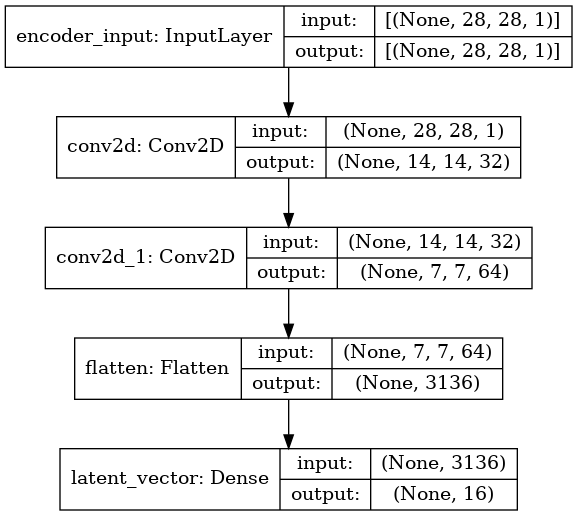

time: 272 ms (started: 2021-08-12 14:18:27 +08:00)


In [5]:
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)

In [6]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

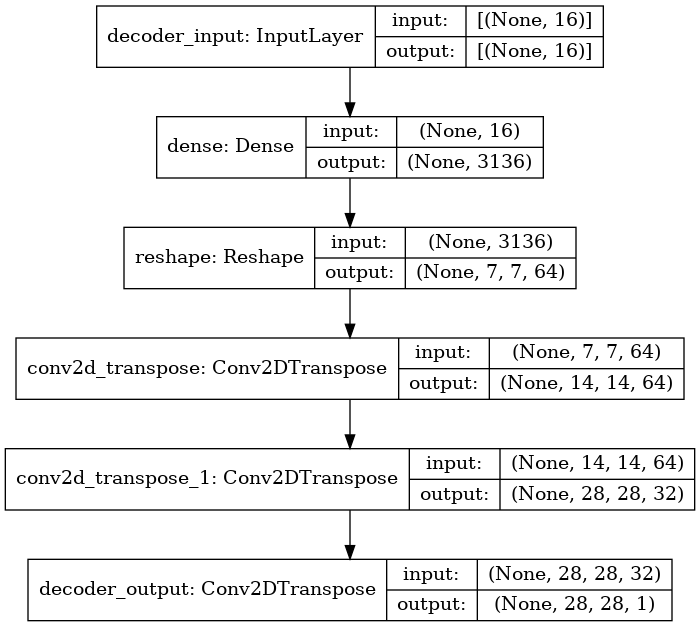

time: 287 ms (started: 2021-08-12 14:25:21 +08:00)


In [7]:
plot_model(decoder, to_file='decoder.png', show_shapes=True)

In [8]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________
time: 80.4 ms (started: 2021-08-12 14:26:58 +08:00)


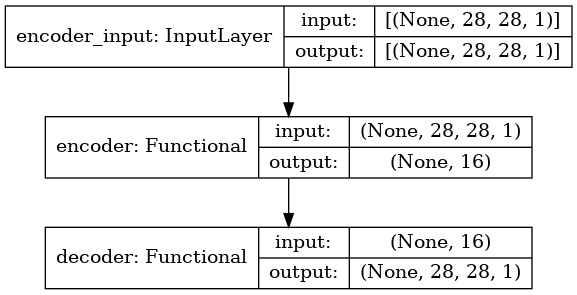

time: 253 ms (started: 2021-08-12 14:27:07 +08:00)


In [9]:
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

In [11]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=10,
                batch_size=batch_size)

Epoch 1/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 2/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 8/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 9/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 10/10
1875/1875 [==============================] - 16s 9ms/step - l

time: 2min 50s (started: 2021-08-12 14:28:55 +08:00)


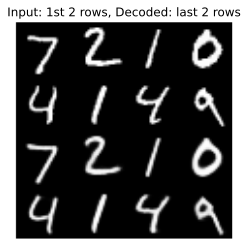

time: 1.56 s (started: 2021-08-12 14:31:51 +08:00)


In [12]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

清单 3.2.1 中的解码器解压缩潜在向量以恢复 MNIST 数字。 解码器输入阶段是一个 Dense 层，它将接受潜在向量。 单位数等于编码器保存的 Conv2D 输出维度的乘积。 这样做是为了我们可以轻松地为 Conv2DTranspose 调整 Dense 层的输出大小，以最终恢复原始 MNIST 图像尺寸。

解码器由三个 Conv2DTranspose 的堆栈组成。 在我们的例子中，我们将使用转置 CNN（有时称为反卷积），它在解码器中更常用。我们可以想象一下换位CNN（Conv2DTranspose）作为CNN的逆过程。

在一个简单的例子中，如果 CNN 将图像转换为特征图，则转置的 CNN 将生成给定特征图的图像。 图 3.2.2 显示了解码器模型：

通过将编码器和解码器连接在一起，我们能够构建自动编码器。 图 3.2.3 说明了自编码器的模型图：

编码器的张量输出也是生成自动编码器输出的解码器的输入。 在这个例子中，我们将使用 MSE 损失函数和 Adam 优化器。 在训练期间，输入与输出相同，x_train。 我们应该注意到，在我们的示例中，只有几层足以在一个 epoch 中将验证损失驱动到 0.01。 对于更复杂的数据集，我们可能需要更深的编码器和解码器，以及更多的训练周期。

在以 0.01 的验证损失训练自动编码器一个 epoch 后，我们能够验证它是否可以编码和解码以前从未见过的 MNIST 数据。 图 3.2.4 向我们展示了来自测试数据的八个样本和相应的解码图像：

除了图像中的轻微模糊之外，我们能够轻松识别出cautoencoder 能够以良好的质量恢复输入。 随着我们训练更多的 epoch，结果会有所改善。

说到这里，我们可能想知道：我们如何在空间中可视化潜在向量？ 一种简单的可视化方法是强制自动编码器使用 2 维潜在向量学习 MNIST 数字特征。 从那里，我们能够将这个潜在向量投影到二维空间上，以查看 MNIST 潜在向量是如何分布的。 图 3.2.5 和图 3.2.6 显示了作为潜在代码维度函数的 MNIST 数字分布。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte03h4vxnj612u0u0n4702.jpg)

在图 3.2.5 中，我们可以看到特定数字的潜在向量聚集在空间区域上。 例如，数字 0 位于左下象限，而数字 1 位于右上象限。 这种聚类反映在图中。 事实上，同一张图显示了从潜在空间导航或生成新数字的结果，如图 3.2.5 所示。

例如，从中心开始并朝向右上象限不同的2暗淡潜矢量的值，这表明我们从9到1。这数字的变化是因为预期的，从图3.2.5，我们 能够看到数字 9 集群的潜在代码值靠近中心，数字 1 代码值集群在右上象限。

对于图 3.2.5 和图 3.2.6，我们只探索了每个潜在向量维度的 -4.0 和 +4.0 之间的区域：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte07dx964j60za0pmq8702.jpg)

从图 3.2.5 中可以看出，潜在代码分布是不连续的。 理想情况下，它应该看起来像一个到处都有有效值的圆圈。 由于这种不连续性，在某些区域，如果我们对潜在向量进行解码，则几乎不会产生任何可识别的数字。

图 3.2.5 和图 3.2.6 是经过 20 轮训练后生成的。 autoencoder-mnist-3.2.1.py 代码通过设置 latent_dim = 2 进行了修改。 plot_results() 函数将 MNIST 数字绘制为 2-dim 潜在向量的函数。 为方便起见，程序保存为 autoencoder-2dim mnist-3.2.2.py，部分代码如清单 3.2.2 所示。 其余代码实际上与代码清单 3.2.1 类似，此处不再显示。

> 清单 3.2.2：autoencoder-2dim-mnist-3.2.2.py

In [14]:
'''Example of autoencoder model on MNIST dataset using 2dim latent

The autoencoder forces the encoder to discover 2-dim latent vector
that the decoder can recover the original input. The 2-dim latent
vector is projected on 2D space to analyze the distribution of code
in the latent space. The latent space can be navigated by varying the
values of latent vector to produce new MNIST digits.

This autoencoder has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os


def plot_results(models,
                 data,
                 batch_size=32,
                 model_name="autoencoder_2dim"):
    """Plots 2-dim latent values as scatter plot of digits
        then, plot MNIST digits as function of 2-dim latent vector

    Arguments:
        models (list): encoder and decoder models
        data (list): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    xmin = ymin = -4
    xmax = ymax = +4
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "latent_2dim.png")
    # display a 2D plot of the digit classes in the latent space
    z = encoder.predict(x_test,
                        batch_size=batch_size)
    plt.figure(figsize=(12, 10))

    # axes x and y ranges
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])

    # subsample to reduce density of points on the plot
    z = z[0::2]
    y_test = y_test[0::2]
    plt.scatter(z[:, 0], z[:, 1], marker="")
    for i, digit in enumerate(y_test):
        axes.annotate(digit, (z[i, 0], z[i, 1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of the digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(xmin, xmax, n)
    grid_y = np.linspace(ymin, ymax, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])
            x_decoded = decoder.predict(z)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 2
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 2)                 6274      
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________
time: 457 ms (started: 2021-08-12 14:52:30 +08:00)


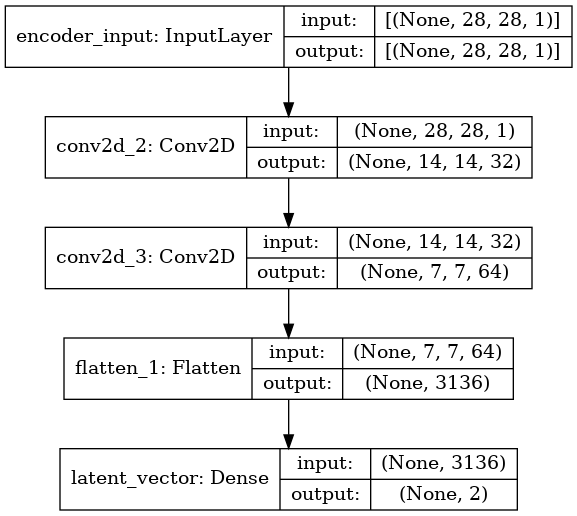

time: 471 ms (started: 2021-08-12 14:52:43 +08:00)


In [15]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

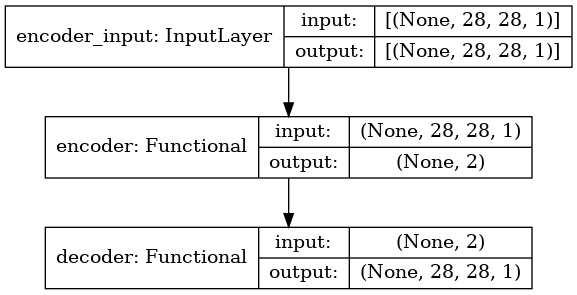

time: 834 ms (started: 2021-08-12 14:52:56 +08:00)


In [16]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

In [17]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=20,
                batch_size=batch_size)

Epoch 1/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0543 - val_loss: 0.0481
Epoch 2/20
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0464 - val_loss: 0.0453
Epoch 3/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 4/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0437 - val_loss: 0.0436
Epoch 5/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0431 - val_loss: 0.0431
Epoch 6/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0427 - val_loss: 0.0428
Epoch 7/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0423 - val_loss: 0.0425
Epoch 8/20
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0421 - val_loss: 0.0422
Epoch 9/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0419 - val_loss: 0.0422
Epoch 10/20
1875/1875 [==============================] - 17s 9ms/step - l

time: 5min 31s (started: 2021-08-12 14:53:14 +08:00)


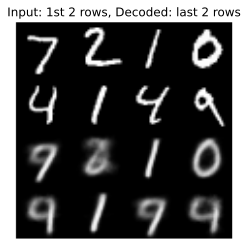

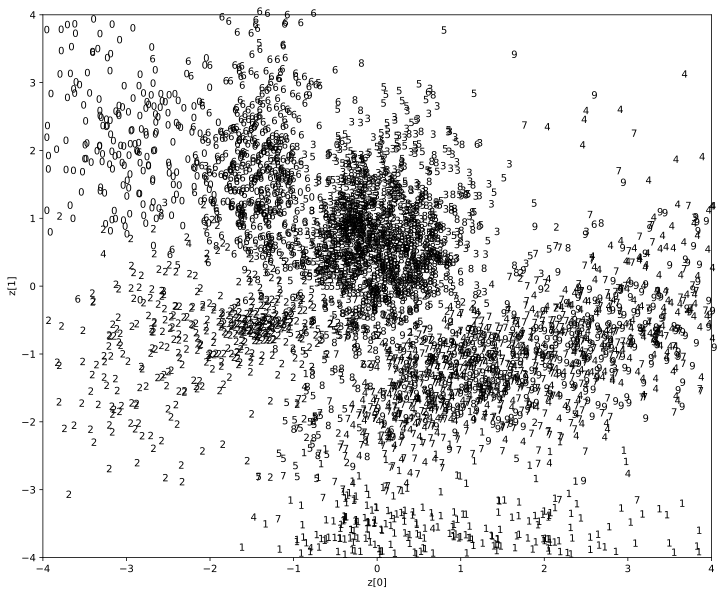

ValueError: The number of FixedLocator locations (31), usually from a call to set_ticks, does not match the number of ticklabels (30).

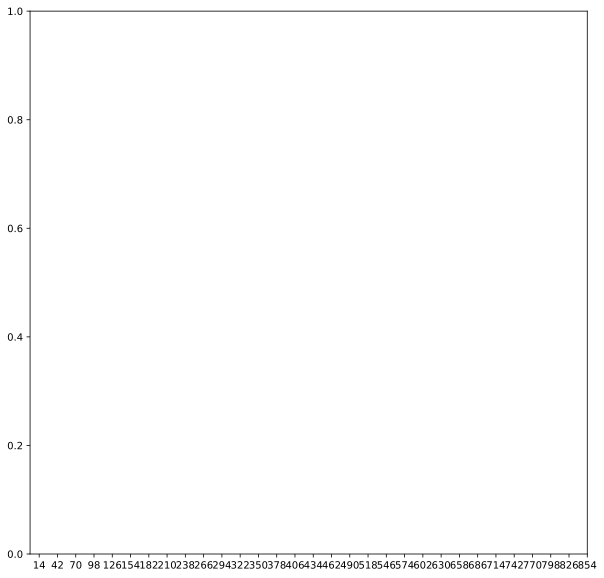

time: 1min 1s (started: 2021-08-12 14:58:46 +08:00)


In [18]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

# project the 2-dim latent on 2D space
models = (encoder, decoder)
data = (x_test, y_test)
plot_results(models, data,
             batch_size=batch_size,
             model_name="autoencoder-2dim")

这样就完成了自动编码器的实现和检查。 接下来的章节将重点介绍它们的实际应用。 我们将从去噪自动编码器开始。

## 去噪自编码器 (DAE)

我们现在将构建一个具有实际应用的自动编码器。 首先，让我们画一张图，想象一下 MNIST 数字图像被噪声破坏了，从而使人类更难阅读。 我们能够构建一个去噪自动编码器 (DAE) 来去除这些图像中的噪声。 图 3.3.1 向我们展示了三组 MNIST 数字。 每组的顶行（例如，MNIST 数字 7、2、1、9、0、6、3、4 和 9）是原始图像。 中间的行显示了 DAE 的输入，它们是被噪声破坏的原始图像。 作为人类，我们可以发现很难读取损坏的 MNIST 数字。 最后一行显示了 DAE 的输出。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte0q2d481j61ko0owjw002.jpg)

如图 3.3.2 所示，去噪自编码器的结构实际上与我们在上一节中介绍的 MNIST 的自编码器相同。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte0qx0p0uj61ki0gc40x02.jpg)

图 3.3.2 中的输入定义为：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte0so80z3j61i4038mx702.jpg)

在这个公式中，xorig 表示被噪声破坏的原始 MNIST 图像。 编码器的目标是发现如何产生潜在向量 z，这将使解码器能够恢复如 MSE，如图所示：xorig 通过最小化相异性损失函数：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte0tto9ubj61h8076wey02.jpg)

在这个例子中，m 是输出维度（例如，在 MNIST 中，m = 宽 × 高 × 通道 = 28 × 28 × 1 = 784）。 Xorigi 和𝑥i 分别是xorig 和𝒙~ 的元素。

要实现 DAE，我们需要对上一节中介绍的内容进行一些更改。 首先，训练输入数据应该是损坏的 MNIST 数字。 训练输出数据是相同的原始干净 MNIST 数字。 这就像告诉自动编码器校正后的图像应该是什么，或者要求它找出如何去除损坏图像的噪声。 最后，我们必须在损坏的 MNIST 测试数据上验证自动编码器。

图 3.3.2 左侧显示的 MNIST 数字 7 是实际损坏的图像输入。 右边的是经过训练的去噪自编码器的干净图像输出。

> 清单 3.3.1: denoising-autoencoder-mnist-3.3.1.py

In [19]:
'''Trains a denoising autoencoder on MNIST dataset.

Denoising is one of the classic applications of autoencoders.
The denoising process removes unwanted noise that corrupted the
true data.

Noise + Data ---> Denoising Autoencoder ---> Data

Given a training dataset of corrupted data as input and
true data as output, a denoising autoencoder can recover the
hidden structure to generate clean data.

This example has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

time: 2min 42s (started: 2021-08-12 15:26:17 +08:00)


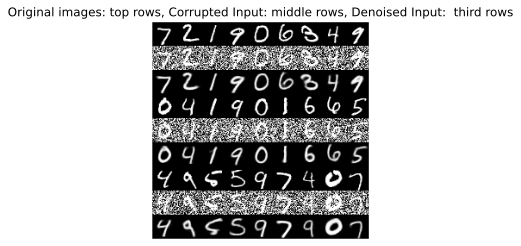

time: 1.27 s (started: 2021-08-12 15:28:59 +08:00)


In [20]:
# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

清单 3.3.1 显示了降噪自动编码器，它已被贡献到官方 Keras GitHub 存储库。 使用相同的 MNIST 数据集，我们能够通过添加随机噪声来模拟损坏的图像。 添加的噪声是高斯分布，均值为 𝜇 = 0.5，标准差为 𝜎 = 0.5。 由于添加随机噪声可能会将像素数据推入小于 0 或大于 1 的无效值，因此将像素值裁剪到 [0.1, 1.0] 范围内。

其他一切都将与上一节中的自动编码器几乎相同。 我们将使用相同的 MSE 损失函数和 Adam 优化器。 但是，训练的 epoch 数增加到 10。这是为了允许充分的参数优化。

图 3.3.3 显示了当噪声水平从 𝜎 = 0.5 增加到 𝜎 = 0.75 和 𝜎 = 1.0 时，DAE 具有一定程度的稳健性。 在𝜎 = 0.75 时，DAE 仍然能够恢复原始图像。 然而，在𝜎𝜎 = 1.0 时，一些数字，例如第二和第三组中的 4 和 5，无法再正确恢复。

我们已经完成了去噪自编码器的讨论和实现。 虽然这个概念是在 MNIST 数字上演示的，但这个想法也适用于其他信号。 在下一节中，我们将介绍自编码器的另一个实际应用，称为着色自编码器。

## 自动着色自动编码器

我们现在将研究自动编码器的另一个实际应用。 在这种情况下，我们将假设我们有一张灰度照片，并且我们想要构建一个可以自动为其添加颜色的工具。 我们想复制人类识别大海和天空是蓝色的，草地和树木是绿色的，而云是白色的等等的能力。

如图 3.4.1 所示，如果给我们一张前景为稻田、背景为火山、顶部为天空的灰度照片（左），我们可以添加适当的颜色（右） .

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte1ic73u1j61e10u010x02.jpg)

一个简单的自动彩色算法似乎是自动编码合适的问题。 如果我们可以用足够数量的灰度照片作为输入并以相应的彩色照片作为输出来训练自动编码器，它就有可能发现正确应用颜色的隐藏结构。粗略地说，它是去噪的逆过程。现在的问题是，能自动编码加彩（良好的噪声）到原来的灰度图像？

清单 3.4.1 显示了着色自动编码器网络。 着色自动编码器网络是我们用于 MNIST 数据集的去噪自动编码器的修改版本。 首先，我们需要一个灰度到彩色照片的数据集。 我们之前使用过的 CIFAR10 数据库有 50,000 张训练和 10,000 张测试 32 × 32 RGB 照片，可以转换为灰度。 如以下清单所示，我们可以使用 rgb2gray() 函数对 R、G 和 B 分量应用权重以将颜色转换为灰度：

> 清单 3.4.1：colorization-autoencoder-cifar10-3.4.1.py

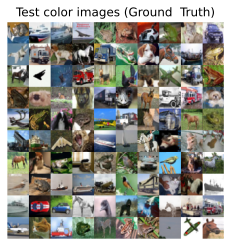

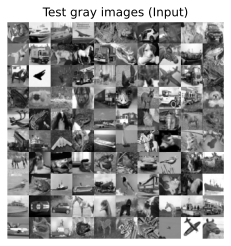

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

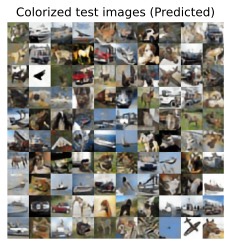

time: 13min 15s (started: 2021-08-12 16:18:08 +08:00)


In [22]:
'''Colorization autoencoder

The autoencoder is trained with grayscale images as input
and colored images as output.
Colorization autoencoder can be treated like the opposite
of denoising autoencoder. Instead of removing noise, colorization
adds noise (color) to the grayscale image.

Grayscale Images --> Colorization --> Color Images
'''

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()

# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

# display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()


# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

# network parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# called every epoch
callbacks = [lr_reducer, checkpoint]

# train the autoencoder
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)

# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()



我们通过再添加一个卷积块和转置卷积块来增加自动编码器的容量。 我们还将每个 CNN 块的过滤器数量增加了一倍。 潜在向量现在是 256-dim，以增加它可以表示的显着属性的数量，如自动编码器部分所述。 最后，输出过滤器大小增加到三个，或等于预期彩色输出的 RGB 通道数。

着色自动编码器现在使用灰度作为输入和原始 RGB 图像作为输出进行训练。 训练将花费更多的 epoch，并在验证损失没有改善时使用学习率降低器来降低学习率。 这可以通过告诉 tf.keras fit() 函数中的 callbacks 参数调用 lr_reducer() 函数来轻松完成。

图 3.4.2 展示了来自 CIFAR10 测试数据集的灰度图像的着色。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte35xe4cdj61100nkdlw02.jpg)

![](https://tva1.sinaimg.cn/large/008i3skNgy1gte39jbv2gj61200myagx02.jpg)

自编码器执行可接受的着色作业。 大海或天空预计是蓝色的，动物有不同深浅的棕色，云是白色的，等等。

有一些明显的错误预测，例如红色车辆变成蓝色或蓝色车辆变成红色，偶尔的绿色区域被误认为是蓝天，黑暗或金色的天空被转换成蓝天。

这是关于自动编码器的最后一节。在下面的章节中，我们将重新编码，并且在一个或另一种形式解码的概念。代表学习的概念是在深度学习非常重要。

## 总结

在本章中，我们已经介绍了自动编码器，它是一种神经网络，可将输入数据压缩为低维表示，以便有效地执行结构转换，例如去噪和着色。我们已经为 GAN 和 VAE 的更高级主题奠定了基础，我们将在后面的章节中介绍这些主题。我们已经演示了如何从两个构建块模型（编码器和解码器）中实现自动编码器。我们还了解了如何提取输入分布的隐藏结构是 AI 中的常见任务之一。

一旦学习了潜在代码，就可以对原始输入分布执行许多结构化操作。为了更好地理解输入分布，隐向量形式的隐藏结构可以使用低级嵌入来可视化，类似于我们在本章中所做的，或者通过更复杂的降维技术，例如 t -SNE 或 PCA。

除了去噪和着色之外，自动编码器还用于将输入分布转换为低维潜在向量，这些潜在向量可以进一步处理以用于其他任务，例如分割、检测、跟踪、重建和视觉理解。 在第 8 章，变分自编码器 (VAE) 中，我们将讨论 VAE，它在结构上与自编码器相同，但不同之处在于具有可解释的潜在代码，可以产生连续的潜在向量投影。

在下一章中，我们将着手介绍人工智能领域近期最重要的突破之一，即 GAN 的引入。 在下一章中，我们将了解 GAN 的核心优势，即它们合成看起来真实的数据的能力。